In [1]:
! nvidia-smi

Fri Jan  6 22:00:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%%shell
pip install torchmetrics --quiet
pip install pytorch-lightning --quiet
pip install pytorch-lightning --quiet
pip install --upgrade wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 15.7 MB/s eta 0:00:00


In [3]:
from collections import OrderedDict
from datetime import datetime
from PIL import Image, ImageDraw, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import math
import numpy as np
import os
import random

import torch
import torch.nn.functional as F
from torch import nn, tensor
from torch.utils.data import DataLoader, random_split, Subset

import torchvision
from torchvision import transforms
from torchvision import models
from torchsummary import summary

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.profiler import AdvancedProfiler

import torchmetrics

from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, ToPILImage
import matplotlib.pyplot as plt

import wandb

import os.path

In [4]:
class TomatoDisease(pl.LightningDataModule):
    def __init__(self, 
                 batch_size, 
                 data_dir: str = '/content/dataset', 
                 train_dataset_path='/content/dataset/train', 
                 test_dataset_path='/content/dataset/valid'):
      
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_dataset_path = train_dataset_path
        self.test_dataset_path = test_dataset_path
        self.image_size = (128, 128)
        self.num_classes = 11
        self.mean = None
        self.std = None
        # self.mean = [0.4538533091545105, 0.4787319004535675, 0.4102860391139984]
        # self.std = [0.2063181847333908, 0.19552414119243622, 0.21730905771255493]

    def prepare_data(self):
        self.download_data()
        self.set_std_and_mean()
        self.transform = Compose([
            Resize(self.image_size), 
            ToTensor(), 
            Normalize(mean=self.mean, std=self.std)
        ])

    def download_data(self):
        if not os.path.exists(self.data_dir):
            ! gdown "1ecmsHNtCrA_cEIaSSWXId3zyjvk7njOk&confirm=t" -O /content/dataset.zip
            ! unzip -u "/content/dataset.zip" -d "/content/dataset"
            ! rm dataset.zip
            ! find /content/ -type f -name '.ipynb_checkpoints' -delete
        
    def set_std_and_mean(self):
        if self.mean != None and self.std != None:
            return

        print("Computing std and mean")
        transform = Compose([Resize(self.image_size), ToTensor()])
        dataset = ImageFolder(self.train_dataset_path, transform=transform)
        dataloader = DataLoader(dataset, batch_size=self.batch_size)

        channelsSum, channelsSquaredSum, numBatches = 0, 0, 0
        for data, _ in dataloader:
            channelsSum += torch.mean(data, dim=[0,2,3])
            channelsSquaredSum += torch.mean(data**2, dim=[0,2,3])
            numBatches += 1
        
        mean = channelsSum / numBatches
        std = (channelsSquaredSum / numBatches - mean ** 2) ** 0.5

        self.mean = mean.tolist()
        self.std = std.tolist()

        print("Std: {std}, Mean: {mean}".format(std=self.std, mean=self.mean))
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            dataset = ImageFolder(self.train_dataset_path, transform=self.transform)
            train_dataset_size = int(len(dataset) * 0.9)
            self.train_dataset, self.val_dataset = random_split(dataset, [train_dataset_size, len(dataset) - train_dataset_size])
        if stage == 'test' or stage is None:
            self.test_dataset = ImageFolder(self.test_dataset_path, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

    def display_sample_images(self):
        image_size = (128, 128)
        transform = Compose([Resize(image_size), ToTensor(), ToPILImage()])
        dataset = ImageFolder(self.train_dataset_path, transform=transform)

        labels_dictionary = {
            0: "Bacterial_spot",
            1: "Early_blight",
            2: "Late_blight",
            3: "Leaf_Mold",
            4: "Septoria_leaf_spot",
            5: "Spider_mites Two-spotted_spider_mite",
            6: "Target_Spot",
            7: "Tomato_Yellow_Leaf_Curl",
            8: "Tomato_mosaic_virus",
            9: "healthy",
            10: "powdery_mildew",
        }
        figure = plt.figure(figsize=(16, 16))
        cols, rows = 4, 4
        for i in range(1, cols * rows + 1):
            index = torch.randint(len(dataset), size=(1,)).item()
            image, label = dataset[index]
            figure.add_subplot(rows, cols, i)
            plt.title(labels_dictionary[label], fontsize=12)
            plt.axis("off")
            plt.imshow(image)
        plt.show()

In [5]:
class Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super(Transition, self).__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(num_input_features, num_output_features, 1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, input):
        x = input
        x = self.relu(self.norm(x))
        x = self.pool(self.conv(x))
        return x

class DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate):
        super(DenseLayer, self).__init__()
        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU()
        self.conv1 = nn.Conv2d(num_input_features, 4 * growth_rate, 1, bias=False)
        self.norm2 = nn.BatchNorm2d(4 * growth_rate)
        self.relu2 = nn.ReLU()
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, 1, bias=False)
        self.drop_out_rate = 0.1
    
    def forward(self, input):
        x = input
        x = self.relu1(self.norm1(x))
        x = self.conv1(x)
        x = self.relu2(self.norm2(x))
        x = self.conv2(x)
        if self.drop_out_rate > 0:
            x = F.dropout(x, p=self.drop_out_rate, training=self.training)
        x = torch.cat((input, x), 1)
        return x

class DenseBlock(nn.Module):
    def __init__(self, num_input_features, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        denseLayers = []
        for i in range(num_layers):
            denseLayers.append(
                DenseLayer(num_input_features + i * growth_rate, growth_rate)
            )
        self.block = nn.Sequential(*denseLayers)
    
    def forward(self, input):
        return self.block(input)

class DenseNet(nn.Module):
    def __init__(self, num_classes, growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64):
        super(DenseNet, self).__init__()

        self.convolution_and_pooling = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        num_features = num_init_features

        dense_blocks_with_transitions = []

        for num_block, num_layers in enumerate(block_config):

            dense_blocks_with_transitions.append(
                DenseBlock(
                    num_input_features=num_features, 
                    growth_rate=growth_rate, 
                    num_layers=num_layers
            ))
            num_features += num_layers * growth_rate

            if num_block != len(block_config) - 1:
                dense_blocks_with_transitions.append(
                    Transition(
                        num_input_features=num_features,
                        num_output_features=num_features // 2
                ))
                num_features = num_features // 2

        self.dense_blocks = nn.Sequential(*dense_blocks_with_transitions)
        self.norm = nn.BatchNorm2d(num_features)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, input):
        x = input 
        x = self.convolution_and_pooling(x)
        x = self.dense_blocks(x)
        x = self.norm(x)
        x = F.relu(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [6]:
def DenseNet121(num_classes, growth_rate=32):
    return DenseNet(num_classes, growth_rate=growth_rate)

def DenseNet169(num_classes, growth_rate=32):
    return DenseNet(
        num_classes, 
        growth_rate=growth_rate,
        block_config=(6, 12, 32, 32), 
        num_init_features=64
    )

def DenseNet201(num_classes, growth_rate=32):
    return DenseNet(
        num_classes, 
        growth_rate=growth_rate,
        block_config=(6, 12, 48, 32), 
        num_init_features=64
    )

In [7]:
device_name = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model_to_summary = DenseNet201(num_classes=11, growth_rate=32).to(device_name)
summary(model_to_summary, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]           8,192
       BatchNorm2d-8          [-1, 128, 32, 32]             256
              ReLU-9          [-1, 128, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]           4,096
       DenseLayer-11           [-1, 96, 32, 32]               0
      BatchNorm2d-12           [-1, 96, 32, 32]             192
             ReLU-13           [-1, 96, 32, 32]               0
           Conv2d-14          [-1, 128,

In [8]:
class Classifier(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=1e-3, logging=True, densenet_type="densenet201"):
        super().__init__()  
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.model = self.get_densenet(densenet_type)
        self.train_metrics = self.get_metrics()
        self.val_metrics = self.get_metrics(prefix="val")
        self.test_metrics = self.get_metrics(prefix="test")
        self.logging = logging

    def get_densenet(self, densenet_type, use_from_pytorch=True):
        if use_from_pytorch:
            return self.get_pytorch_densenet(densenet_type)
        
        if densenet_type == "densenet121":
            return DenseNet121(num_classes=self.num_classes)
        elif densenet_type == "densenet169":
            return DenseNet169(num_classes=self.num_classes)
        else:
            return DenseNet201(num_classes=self.num_classes)

    def get_pytorch_densenet(self, densenet_type):
        model = None
        if densenet_type == "densenet121":
            model = models.densenet121()
        elif densenet_type == "densenet169":
            model = models.densenet169()
        else:
            model = models.densenet201()
        
        num_features = model.classifier.in_features 
        model.classifier = nn.Sequential(
            nn.Linear(num_features, 256),  
            nn.LeakyReLU(), 
            nn.Linear(256, self.num_classes))
        return model

    def get_metrics(self, prefix="train"):
        return torchmetrics.MetricCollection([
            torchmetrics.Accuracy(task="multiclass", num_classes=self.num_classes, average="macro"),
            torchmetrics.Precision(task="multiclass", num_classes=self.num_classes, average="macro"),
            torchmetrics.Recall(task="multiclass", num_classes=self.num_classes, average="macro"),
            torchmetrics.F1Score(task="multiclass", num_classes=self.num_classes, average="macro"),
        ], prefix=prefix)

    def forward(self, x):
        return self.model(x)

    def compute_loss(self, x, y): 
        return F.cross_entropy(x, y)

    def common_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.compute_loss(outputs,y)
        preds = torch.argmax(outputs, dim=1)
        return loss, preds, y

    def training_step(self, batch, batch_idx):
        loss, preds, y = self.common_step(batch, batch_idx)
        self.train_metrics.update(preds, y)
        if self.logging:
            wandb.log({"trainLoss": loss })
        return loss

    def train_epoch_end(self, outs):
        result = self.train_metrics.compute()
        if self.logging:
            wandb.log(result)
        self.train_metrics.reset()
        
    def validation_step(self, batch, batch_idx):
        loss, preds, y = self.common_step(batch, batch_idx)
        self.val_metrics.update(preds, y)
        return loss

    def validation_epoch_end(self, outs):
        loss = torch.tensor(outs).mean()
        result = self.val_metrics.compute()
        result.update({"valLoss": loss}) 
        if self.logging:
            self.log("valLoss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
            wandb.log(result)
        self.val_metrics.reset()

    def test_step(self, batch, batch_idx):
        loss, preds, y = self.common_step(batch, batch_idx)
        self.test_metrics.update(preds, y)
        return loss

    def test_epoch_end(self, outs):
        loss = torch.tensor(outs).mean()
        result = self.test_metrics.compute()
        result.update({"testLoss": loss}) 
        if self.logging:
            wandb.log(result)
        self.test_metrics.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [9]:
datamodule = TomatoDisease(batch_size=21)
datamodule.prepare_data()

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/valid/Late_blight/9c274db5-2f89-4f3c-b9e2-4d5ebc54ddad___GHLB2 Leaf 9096.JPG  
  inflating: /content/dataset/valid/Late_blight/9c726f4e-045b-4080-b53d-d7e66d45bcb1___RS_Late.B 4876.JPG  
  inflating: /content/dataset/valid/Late_blight/9e5dd34f-124c-4a64-ba9f-77c8d05faa9c___GHLB2 Leaf 8749.JPG  
  inflating: /content/dataset/valid/Late_blight/9e633823-3dde-450c-8172-733021e4dff0___RS_Late.B 6414.JPG  
  inflating: /content/dataset/valid/Late_blight/9ecb8001-2f48-4487-b287-535dbcfb5c2f___RS_Late.B 6206.JPG  
  inflating: /content/dataset/valid/Late_blight/9f7dcd60-e691-4c1e-830e-7495f7cc123d___RS_Late.B 6166.JPG  
  inflating: /content/dataset/valid/Late_blight/Bacterial_spots2276_jpg.rf.5becd3793ec2a532bf8f111d60911c63.jpg  
  inflating: /content/dataset/valid/Late_blight/IMG_1526_jpg.rf.5e25005985e2b12a6f52bfa7120f3eee.jpg  
  inflating: /content/dataset/valid/Late_blight/IMG_5360_jpg.rf.7651a731881c678ec1

In [10]:
class_names = sorted(os.listdir(datamodule.train_dataset_path))

print(f"Number of classes: {datamodule.num_classes}")
print("Classes:")
for name in class_names:
    print(f" - {name}")

Number of classes: 11
Classes:
 - Bacterial_spot
 - Early_blight
 - Late_blight
 - Leaf_Mold
 - Septoria_leaf_spot
 - Spider_mites Two-spotted_spider_mite
 - Target_Spot
 - Tomato_Yellow_Leaf_Curl_Virus
 - Tomato_mosaic_virus
 - healthy
 - powdery_mildew


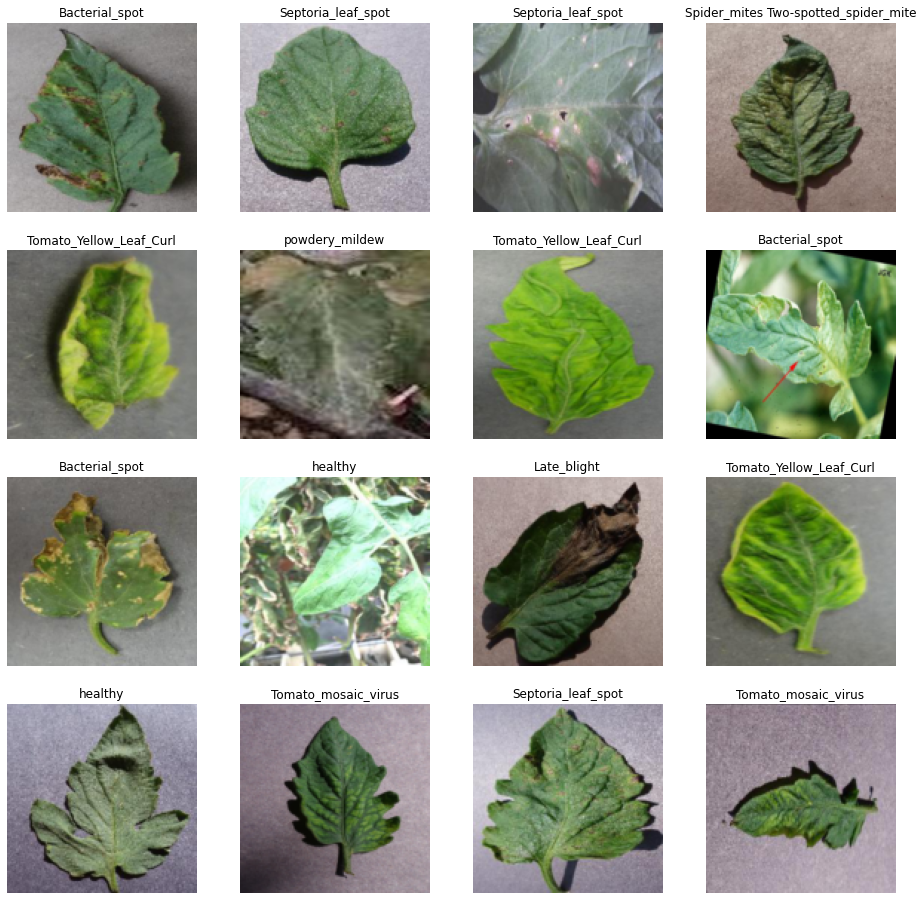

In [11]:
datamodule.display_sample_images()

In [12]:
densenet_type = "densenet169"

In [13]:
def get_learning_rate(datamodule):
    model = Classifier(num_classes=datamodule.num_classes, logging=False, densenet_type=densenet_type)
    trainer = pl.Trainer(gpus=1, max_epochs=5, auto_lr_find=False)
    tuner = trainer.tuner

    lr_finder = tuner.lr_find(model, datamodule)

    lr_finder.results
    fig = lr_finder.plot(suggest=True)
    fig.show()
    learning_rate = lr_finder.suggestion()

    return learning_rate

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_c1341972-9f62-4f44-bc59-a5c0ec218f78.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/.lr_find_c1341972-9f62-4f44-bc59-a5c0ec218f78.ckpt


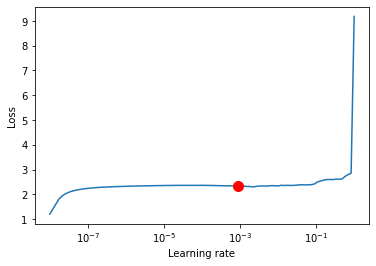

In [19]:
learning_rate = get_learning_rate(datamodule)

In [20]:
print(f"Learning rate: {learning_rate}")

Learning rate: 0.0009120108393559097


In [21]:
model = Classifier(num_classes=datamodule.num_classes, learning_rate=learning_rate, densenet_type=densenet_type)

In [22]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [23]:
wandb.init(project="TomatoDiseaseClassification", entity="matiziel-team")

wandb.config = {
  "learning_rate": learning_rate,
  "epochs": 16,
  "batch_size": 21
}

wandb: Currently logged in as: matiziel (matiziel-team). Use `wandb login --relogin` to force relogin


In [24]:
early_stop_callback = EarlyStopping(monitor="valLoss", patience=5, mode="min")
logger = WandbLogger(project="TomatoDiseaseClassification", log_model=True)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:322: UserWarning: Providing log_model=True requires wandb version >= 0.10.22 for logging associated model metadata.
Hint: Upgrade with `pip install --upgrade wandb`.
  rank_zero_warn(


In [25]:
trainer = pl.Trainer(
    accelerator='gpu', 
    devices=1, 
    auto_select_gpus=True,
    amp_backend='native',
    check_val_every_n_epoch=1, 
    max_epochs=16,
    benchmark=False, 
    callbacks=[early_stop_callback], 
    logger=logger
)

INFO:pytorch_lightning.trainer.connectors.accelerator_connector:Auto select gpus: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [37]:
trainer.fit(model=model, datamodule=datamodule)
trainer.save_checkpoint("/content/model_checkpoint.ckpt")

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory ./TomatoDiseaseClassification/version_None/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | DenseNet         | 12.9 M
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.654    Total estimated model params size (MB)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already i

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=16` reached.


In [26]:
def download_model_checkpoint():
    checkpoint_path="/content/model_checkpoint.ckpt"
    if not os.path.isfile(checkpoint_path):
        # ! gdown "1p7H94OiF23_ngwMWcuSxZYy13r6TtSaM&confirm=t" -O /content/model_checkpoint.ckpt
        ! gdown "1tPPt_INvOC3JQ1qp65y2_ajXTEs5S3We&confirm=t" -O /content/model_checkpoint.ckpt

        

In [27]:
download_model_checkpoint()

Downloading...
From: https://drive.google.com/uc?id=1tPPt_INvOC3JQ1qp65y2_ajXTEs5S3We&confirm=t
To: /content/model_checkpoint.ckpt
100% 156M/156M [00:04<00:00, 34.3MB/s]


In [28]:
model = Classifier.load_from_checkpoint(checkpoint_path="/content/model_checkpoint.ckpt")

In [29]:
trainer.test(model=model, datamodule=datamodule)
wandb.finish()

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

testLoss,▁
testMulticlassAccuracy,▁
testMulticlassF1Score,▁
testMulticlassPrecision,▁
testMulticlassRecall,▁
testLoss,0.21161
testMulticlassAccuracy,0.94271
testMulticlassF1Score,0.94198
testMulticlassPrecision,0.94174
testMulticlassRecall,0.94271


Wyniki eksperymentów dostępne pod adresem: https://wandb.ai/matiziel-team/TomatoDiseaseClassification?workspace=user-matiziel

# Bibliografia 
- https://arxiv.org/abs/1608.06993
- https://amaarora.github.io/2020/08/02/densenets.html
- https://towardsdatascience.com/paper-review-densenet-densely-connected-convolutional-networks-acf9065dfefb
- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataloader
- https://pytorch-lightning.readthedocs.io/en/1.6.3/common/checkpointing.html
